<a href="https://colab.research.google.com/github/layely/DeepLearning-Course-UdeM/blob/master/TP1_MobileNetV2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation


## Connect to Google Drive


In [0]:
# Code to read csv file into Colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.8MB/s 


## Download dataset (zip file)

In [0]:
# Download dataset (chest_xray.zip)

# Gdrive link of the dataset 
link = 'https://drive.google.com/open?id=1UmA1WKqZfOkN0EP5lno8h9aAbFDIZ-hQ'
  
_, id = link.split('=')

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('chest_xray.zip')

## Extract dataset archive

In [0]:
# Extract dataset archive

import os
import zipfile

EXTRACT_PATH = "chest_x_ray_mobilenet_mobile"


try:
  !rm -r {EXTRACT_PATH}
except:
  pass

archive = zipfile.ZipFile('chest_xray.zip', 'r')
archive.extractall(path=EXTRACT_PATH)


if os.path.isdir(EXTRACT_PATH):
  print("archive successfully extracted")
else:
  print("Can't extract archive")
  


rm: cannot remove 'chest_x_ray_mobilenet_mobile': No such file or directory
archive successfully extracted


In [0]:
!ls {EXTRACT_PATH}/chest_xray

test  train  val


## Re-balance train/val distribution
**To run only once!!!**

At this point, the validation set consist of only 16 images. In order to improve the robustness of the model, we copy from the training 2x216 images to increase the proportion of images in the validation set.

In [0]:

# By default we have only 16 images in the validation folder
# To rebalance the distribution train/val, we copy a subset from
# train folder to val folder

!mv `ls -d {EXTRACT_PATH}/chest_xray/train/NORMAL/* | head -216` {EXTRACT_PATH}/chest_xray/val/NORMAL/ #112
!mv `ls -d {EXTRACT_PATH}/chest_xray/train/PNEUMONIA/* | head -216` {EXTRACT_PATH}/chest_xray/val/PNEUMONIA/
#!ls chest_xray/train/PNEUMONIA | head -10

## Load dataset with ImageGenerators

We load the dataset via ImageDataGenerator provided in Keras. We also applied some augmentation on the training and validation set which slightly improved our models performance during testing. The transformations includes random horizontal flipping (for both training et validation) and small rotation (<=10°) and zoom (<=0.1) only on the training set.

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, \
  img_to_array, load_img
from keras.applications.nasnet import preprocess_input


def getImageGenerators(target_size=(224, 224), batch_size=16):
  train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
  val_datagen = ImageDataGenerator(horizontal_flip=True, preprocessing_function=preprocess_input)
  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      directory=r"./{}/chest_xray/train/".format(EXTRACT_PATH),
      target_size=target_size,
      color_mode="rgb",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=64
  )

  val_generator = val_datagen.flow_from_directory(
      directory=r"./{}/chest_xray/val/".format(EXTRACT_PATH),
      target_size=target_size,
      color_mode="rgb",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=64
  )

  test_generator = test_datagen.flow_from_directory(
      directory=r"./{}/chest_xray/test/".format(EXTRACT_PATH),
      target_size=target_size,
      color_mode="rgb",
      batch_size=1,
      class_mode='categorical',
      shuffle=False,
      seed=64
  )

  return train_generator, val_generator, test_generator 

Using TensorFlow backend.


# Model definition

Here we define our model architecture based on a pretrained MobileNetV2. The top of the network is removed  and replaced with two fully connected layers preceded by a 0.5 Dropout each. Before the fully connected layers are plugged to the network, we applied a Global average pooling to the base model. The final model consist of 160 layers and 2,340,098 params in total.

In [0]:
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.vis_utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2
import matplotlib.image as mpimg

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def getModel(input_shape, loss, optimizer, activation, num_freeze=0):
  base_model = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)
  
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  x = Dense(64, activation=activation)(x)
  x = Dropout(0.5)(x)
  y = Dense(2, activation='softmax')(x)
  
  model = Model(inputs=base_model.input, outputs=y)
  
  # Freeze layers the first 'num_freeze' layers 
  for layer in model.layers[:num_freeze]:
    layer.trainable = False
  for layer in model.layers[num_freeze:]:
    layer.trainable = True
  
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

# Visualize model
model = getModel(input_shape=(224,224,3), loss="categorical_crossentropy", optimizer="rmsprop", activation="relu")
model.summary()
print("Number of layers:", len(model.layers))
"""
# For a more fancy visualization
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

img = mpimg.imread('model_plot.png')
plt.figure(figsize = (10,30))
plt.imshow(img, interpolation='nearest')
"""

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
_________________________________________________________

"\n# For a more fancy visualization\nplot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)\n\nimg = mpimg.imread('model_plot.png')\nplt.figure(figsize = (10,30))\nplt.imshow(img, interpolation='nearest')\n"

# Training

## Callbacks

Here we define two callbacks: 
* `reduce_lr_callback` which reduces the learning rate by a factor of 0.2 when the validation loss is almost static after 5 epochs.
* `checkpoint_acc_callback` which save the entire model after each epoch where we get a better validation accuracy.

In [0]:
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

SAVED_MODEL_PATH = "best_model_MobileNetV2.h5"
checkpoint_acc_callback = ModelCheckpoint(SAVED_MODEL_PATH, monitor='val_acc', verbose=0, save_best_only=True, 
                                save_weights_only=False, mode='max', period=1)

## Optimization

In this subsection, we just defined various configurations of optimizers, tested each of them and found out that Adam with a learning rate of 0.001 and no decay gives usually the best results during our experimentations (perfomed outside collabs as it very hard training on it for many hours)

In [0]:
from keras import optimizers

# List useful only during parameter optimization
optimizers_list = [
    # SGD
    optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False),#1
    optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=True),
    optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
    optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True),
    optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
    optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
    optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),
    # Adagrad
    optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0),#8
    optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=1e-6),
    optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0),
    optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=1e-6),
    optimizers.Adagrad(lr=0.001, epsilon=1e-08, decay=0.0),
    optimizers.Adagrad(lr=0.001, epsilon=1e-08, decay=1e-6),
    # AdaDelta
    optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0), #14
    optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=1e-6),
    optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=1e-08, decay=0.0),
    optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=1e-08, decay=1e-6),
    optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=1e-08, decay=0.0),
    optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=1e-08, decay=1e-6),
    optimizers.Adadelta(lr=0.001, rho=0.95, epsilon=1e-08, decay=0.0),
    optimizers.Adadelta(lr=0.001, rho=0.95, epsilon=1e-08, decay=1e-6),
    
    # RMSprop
    optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=1e-08, decay=0.0),#22
    optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=1e-08, decay=1e-6),
    optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0),
    optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=1e-6),
    optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
    optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=1e-6),
    
    # Adam
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),#28
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), # Gives the best results
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
    
    # Adam amsgrad=True
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True),#34
    optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6, amsgrad=True),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True),
    optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6, amsgrad=True),
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True),
    optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6, amsgrad=True)
                  ]

## Init model parameters

In this subsections we initialize the training parameters. We use Cross-Entropy as our loss function and Adam with a learning rate of 0.001 as optimizer. We also uses a batch size of 16 during training and our network takes inputs with shape 224x224x3. In contrary to our DenseNet model, no layer from the base network is freesed. Finally, our sets are organised as follow: 4784 images for training, 448 for validation and 624 for test.

In [0]:
from keras import optimizers

# Set training hyperparameters
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
NUM_EPOCHS = 50

loss = "categorical_crossentropy"
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
activation = "relu"

# Since we have 3x more images for Pneunomia,
# weigths the loss to focus more on classifying
# correctly the normal chests.
class_weight = [0.3, 0.1]

model = getModel(input_shape=(INPUT_WIDTH, INPUT_HEIGHT, 3), loss=loss,
                 optimizer=optimizer, activation=activation, num_freeze=0)

train_gen, val_gen, test_gen = getImageGenerators(target_size=(INPUT_WIDTH, INPUT_HEIGHT), 
                                                 batch_size=16)

print(train_gen.classes)

# Number of steps (for train and val) per epoch during train
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_val = (val_gen.n // val_gen.batch_size)
if step_size_val == 0:
  step_size_val = 1

Found 4784 images belonging to 2 classes.
Found 448 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
[0 0 0 ... 1 1 1]


## Fit Models


In [0]:
!ls

adc.json  chest_x_ray_mobilenet_mobile	chest_xray.zip	sample_data


In [0]:
# Run training
history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=step_size_train,
                    validation_data=val_gen,
                    validation_steps=step_size_val,
                    use_multiprocessing=True,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    #class_weight=class_weight,
                    shuffle=True,
                    callbacks=[checkpoint_acc_callback, reduce_lr_callback]
)


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
299/299 [==============================] - 163s 544ms/step - loss: 0.2068 - acc: 0.9277 - val_loss: 0.4880 - val_acc: 0.8371
Epoch 2/50
299/299 [==============================] - 145s 486ms/step - loss: 0.1344 - acc: 0.9557 - val_loss: 6.2008 - val_acc: 0.5692
Epoch 3/50
299/299 [==============================] - 147s 491ms/step - loss: 0.1314 - acc: 0.9578 - val_loss: 5.1824 - val_acc: 0.5357
Epoch 4/50
299/299 [==============================] - 145s 486ms/step - loss: 0.1144 - acc: 0.9611 - val_loss: 2.3203 - val_acc: 0.5759
Epoch 5/50
299/299 [==============================] - 146s 487ms/step - loss: 0.0832 - acc: 0.9728 - val_loss: 3.1096 - val_acc: 0.6406
Epoch 6/50
299/299 [==============================] - 146s 488ms/step - loss: 0.0765 - acc: 0.9716 - val_loss: 1.0928 - val_acc: 0.7946
Epoch 7/50
299/299 [==============================] - 143s 480ms/step - loss: 0.0874 - acc: 0.9722 - val_loss: 5.0154 - val_acc: 0.5826


## Learning curves
The training loss and accuracy almost instantly reached the pick and stayed on plateau while the validation loss and accuracy was overall evolving by following a zigzag pattern with a val accuracy reaching a maximum of +98% after 45 epochs.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


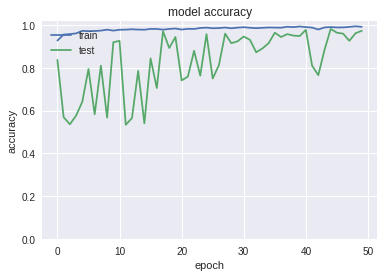

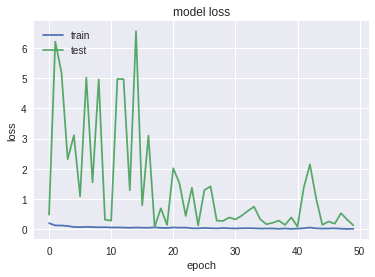

In [0]:
import matplotlib.pyplot as plt

print(history.history.keys())

# Plot curve for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(bottom=0)
plt.show()

# Plot curve for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model evaluation

## Acuracy and Loss scores

The model performed an **accuracy of 87.18%** on the testing set which is the best result among the three models on this metric. Though the comparison with DenseNet is not fair since all of its layers was freezed during training.

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.models import load_model

# Load best model
model = load_model(SAVED_MODEL_PATH)

loss, accuracy = model.evaluate_generator(generator=test_gen, steps=test_gen.n)
print("Loss: {}    ---    Accuracy: {}%".format(round(loss, 3), round(accuracy * 100, 2)))

Loss: 1.355    ---    Accuracy: 87.18%


In [0]:
!ls -l --block-size=M

total 1197M
-rw-r--r-- 1 root root    1M Mar 23 21:35 adc.json
-rw-r--r-- 1 root root   28M Mar 23 23:26 best_model_MobileNetV2.h5
drwxr-xr-x 3 root root    1M Mar 23 21:35 chest_x_ray_mobilenet_mobile
-rw-r--r-- 1 root root 1169M Mar 23 21:35 chest_xray.zip
drwxr-xr-x 1 root root    1M Mar  8 17:26 sample_data


## Confusion Matrix

The confusion matrix shows that we have fewer false positives than the DenseNet model but higher than our custom model. However, this model have a lower false negative rate than our custom model.

Number of predicted normal cases: 170


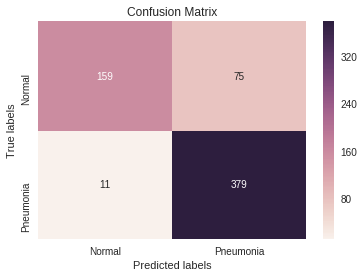

In [0]:
# Install seaborn, for a fancy (heated) confusion matrix
!pip install seaborn
import seaborn as sns

Y_pred = model.predict_generator(generator=test_gen, steps=test_gen.n)

y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes # Array of true labels

pred_normal = [i for i in y_pred if i == 0]
print("Number of predicted normal cases:", len(pred_normal))

cm = confusion_matrix(y_true, y_pred)  

# Plot confusion matrix

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Pneumonia', 'Normal']);

## Precision, Recall and F1score 

In [0]:
print('Classification Report')
target_names = ['NORMAL', 'PNEUNOMIA']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.94      0.68      0.79       234
   PNEUNOMIA       0.83      0.97      0.90       390

   micro avg       0.86      0.86      0.86       624
   macro avg       0.89      0.83      0.84       624
weighted avg       0.87      0.86      0.86       624



## ROC curve

The area under the curve is 92% which is slightly less good than our custom model (95%). As in the custom model ROC curve, we can reach a detection accuracy of ~90% on true positive while keeping the rate of false positives as low as ~10%.

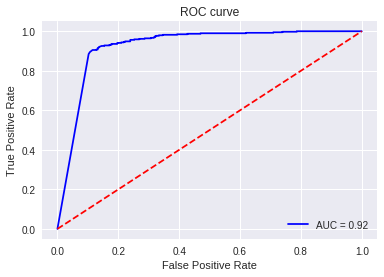

In [0]:
# Predicted probability scores for pneumnia (positives)
pneumnia_scores = Y_pred[:, 1]

# y_true defined in "Confusion Matrix" section represent
# the labels (observed value)
fpr, tpr, thresholds = roc_curve(y_true, pneumnia_scores)
roc_auc = auc(fpr, tpr)

# PLot the roc curve
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Exemples of good and bad predictions

We can assert after observing the images and the labels and predictions that the networks are not doing the same mistakes at all. 

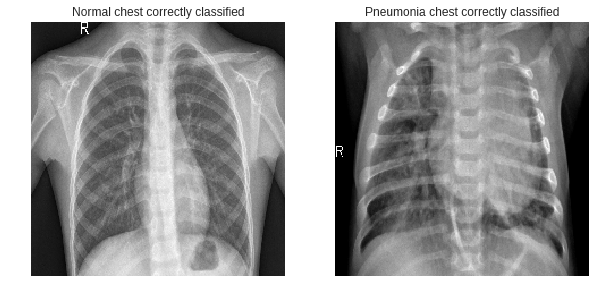

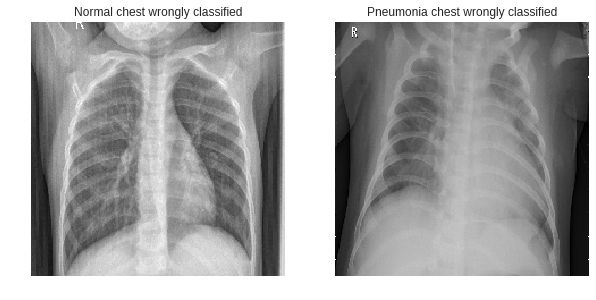

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [0]:
""" Get image at index specified from the test set """
def getTestImageFromIndex(index):
  return test_gen.__getitem__(index)[0]

def show_images_side_by_side(img1, img2, title1, title2, cmap=None, clim=None, reshape=True):
  if reshape == True:
    img1 = img1.reshape(INPUT_WIDTH, INPUT_HEIGHT, 3)
    img2 = img2.reshape(INPUT_WIDTH, INPUT_HEIGHT, 3)
  
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))
  ax1.imshow(img1, cmap=cmap, clim=clim)
  ax2.imshow(img2, cmap=cmap, clim=clim)
  ax1.set_title(title1)
  ax2.set_title(title2) 
  ax1.set_axis_off()
  ax2.set_axis_off()
  plt.show()
  
def denormalize_image(x):
  """ 
    When loading the images with ImageDataGenerator in section load dataset
    image was normalized with the function preprocess_image defined in 
    https://github.com/keras-team/keras-applications/blob/8c5f4fbc5833911ddb02e8257eff9ade22e8c0ea/keras_applications/imagenet_utils.py#L45
    So we denormalize the images to restore its original format before showing it with matplotlib.
  """
  x += 1.
  x *= 127.5/255.
  return x

# Get one indexe of correct negative (normal chest) and correct positive (pneumonia) prediction
correct_pred_of_normal_chest = [i for i, x in enumerate(y_true) if x == 0 and x == y_pred[i]][0]
correct_pred_of_pneumonia_chest = [i for i, x in enumerate(y_true) if x == 1 and x == y_pred[i]][0]

# Get one indexe of wrong negative (normal chest) and wribg positive (pneumonia) prediction
wrong_pred_of_normal_chest = [i for i, x in enumerate(y_true) if x == 0 and x != y_pred[i]][0]

# Currently all Pneumonia are correctly classified due to data unbalance
try:
  wrong_pred_of_pneumonia_chest = [i for i, x in enumerate(y_true) if x == 1 and x != y_pred[i]][0]
  tile4 = "Pneumonia chest wrongly classified"
except:
  # No case of wrongly classified pneumonia
  # We also make sure we do not pick the index of wrong_pred_of_normal_chest
  wrong_pred_of_pneumonia_chest = [i for i, x in enumerate(y_true) if x != y_pred[i] and i != wrong_pred_of_normal_chest][0]
  tile4 = "Another normal chest wrongly classified"

correct_pred_normal_chest_img = denormalize_image(getTestImageFromIndex(correct_pred_of_normal_chest))
correct_pred_pneumonia_chest_img = denormalize_image(getTestImageFromIndex(correct_pred_of_pneumonia_chest))

wrong_pred_normal_chest_img = denormalize_image(getTestImageFromIndex(wrong_pred_of_normal_chest))
wrong_pred_pneumonia_chest_img = denormalize_image(getTestImageFromIndex(wrong_pred_of_pneumonia_chest))

show_images_side_by_side(correct_pred_normal_chest_img, 
                         correct_pred_pneumonia_chest_img, 
                         "Normal chest correctly classified",
                         "Pneumonia chest correctly classified")

show_images_side_by_side(wrong_pred_normal_chest_img, 
                         wrong_pred_pneumonia_chest_img, 
                         "Normal chest wrongly classified",
                         tile4)
# Show array of true labels and predicted values
print(y_true)
print('---------------------------------------------------------------------')
print(y_pred)

# Investigate

Here we shows the deep taylor attention map of the images shown in the previous section. The attention map highlights the pixels that contributed more in the final decision (prediction).

In [0]:
# Install innvestigate, a tool for neural network analysis
# link - https://github.com/albermax/innvestigate
# We will use it to create the attention map of an input (image)
!pip install innvestigate

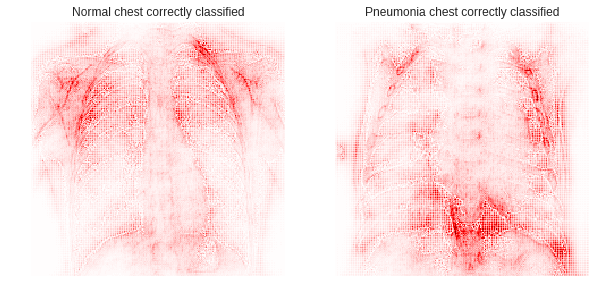

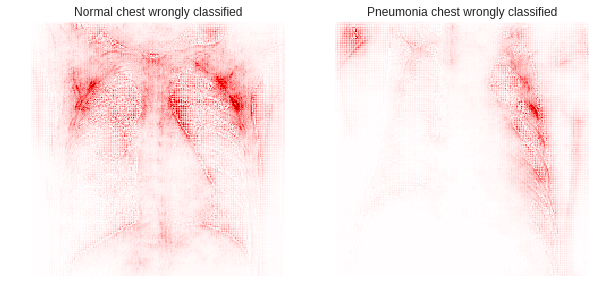

In [0]:
import innvestigate

def getDeepTaylorMap(model, image_index): 
  # Model without softmax
  model_ws = innvestigate.utils.model_wo_softmax(model)

  # Create analyzer
  analyzer = innvestigate.create_analyzer("deep_taylor", model_ws)
  
  image = getTestImageFromIndex(image_index)
  resultImage = analyzer.analyze(image)

  # Aggregate along color channels and normalize to [-1, 1]
  resultImage = resultImage.sum(axis=np.argmax(np.asarray(resultImage.shape) == 3))
  resultImage /= np.max(np.abs(resultImage))
  return resultImage[0]

correct_pred_of_normal_chest_dtmap = getDeepTaylorMap(model, correct_pred_of_normal_chest)
correct_pred_of_pneumonia_chest_dtmap = getDeepTaylorMap(model, correct_pred_of_pneumonia_chest)

wrong_pred_of_normal_chest_dtmap = getDeepTaylorMap(model, wrong_pred_of_normal_chest)
wrong_pred_of_pneumonia_chest_dtmap = getDeepTaylorMap(model, wrong_pred_of_pneumonia_chest)

# Plot
#plt.title("Normal image correctly predicted")
#plt.imshow(correct_pred_of_normal_chest_dtmap, cmap="seismic", clim=(-1, 1))

show_images_side_by_side(correct_pred_of_normal_chest_dtmap, correct_pred_of_pneumonia_chest_dtmap, 
                         "Normal chest correctly classified", "Pneumonia chest correctly classified",
                         cmap="seismic", clim=(-1, 1), reshape=False)

show_images_side_by_side(wrong_pred_of_normal_chest_dtmap, wrong_pred_of_pneumonia_chest_dtmap, 
                         "Normal chest wrongly classified", "Pneumonia chest wrongly classified",
                         cmap="seismic", clim=(-1, 1), reshape=False)


# Save best model in my Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#!ls "/content/drive/My Drive"
TP_DL_dir = "/content/drive/My\ Drive/TP_DL"
BEST_MODEL = (TP_DL_dir + "/mobilenetv2_model.hd5").replace('\ ', ' ')
BEST_WEIGHTS = (TP_DL_dir + "/mobilenetv2_weights.hd5").replace('\ ', ' ')

model.save_weights(BEST_WEIGHTS)
model.save(BEST_MODEL)

!ls {TP_DL_dir}

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/TP_DL/mobilenetv2_model.hd5
densenet_model.hd5    mobilenetv2_model.hd5    own_model.hd5
densenet_weights.hd5  mobilenetv2_weights.hd5  own_model_weights.hd5


# References
1. https://keras.io/
2. https://scikit-learn.org/stable/documentation.html
3. https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785#answer-48018785
4. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python?rq=1#answer-38467407
5. https://github.com/albermax/innvestigate